# Gather data

The idea is to gather a subset of Amazon Customer Reviews for each product category, without downloading huge TSV files. Since Amazon stores this data in public S3 buckets, we will use Amazon Athena for data extraction.

Requires an AWS account.

Before starting, head over to the Amazon Athena console and manually create a table as described [here](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

In [101]:
import boto3
import pandas as pd
import io
import re
import os
import time
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

## Find the Athena bucket on S3

After creating the table, Athena will automatically create an S3 bucket, which we will use to store the results of our queries. 

In [2]:
session = boto3.Session()

In [3]:
def list_buckets(session):
    """List all buckets."""
    s3 = session.client('s3')
    response = s3.list_buckets()
    buckets = [bucket['Name'] for bucket in response['Buckets']]
    print(buckets)

In [4]:
list_buckets(session)

['aws-athena-query-results-953225455667-us-west-2', 'polakowo-yelp2', 'sagemaker-us-west-2-953225455667']


In [5]:
# You will see a bucket name similar to aws-athena-query-results->region<->account-id<
# if you followed instructions in https://s3.amazonaws.com/amazon-reviews-pds/readme.html
bucket = 'aws-athena-query-results-953225455667-us-west-2'

In [8]:
params = {
    'region': 'us-west-2',
    'database': 'default',
    'bucket': bucket,
    'path': 'temp/amazon-reviews'
}

## List product categories

Fetch the available product categories.

In [31]:
# https://www.ilkkapeltola.fi/2018/04/simple-way-to-query-amazon-athena-in.html
def athena_query(client, params):
    """Query Athena."""
    response = client.start_query_execution(
        QueryString=params["query"],
        QueryExecutionContext={
            'Database': params['database']
        },
        ResultConfiguration={
            'OutputLocation': 's3://' + params['bucket'] + '/' + params['path']
        }
    )
    return response

In [84]:
def athena_to_s3(session, params):
    """Query Athena and get the S3 filename as a result."""
    client = session.client('athena', region_name=params["region"])
    execution = athena_query(client, params)
    execution_id = execution['QueryExecutionId']
    state = 'RUNNING'

    while state in ['RUNNING']:
        response = client.get_query_execution(QueryExecutionId=execution_id)

        if 'QueryExecution' in response and \
                'Status' in response['QueryExecution'] and \
                'State' in response['QueryExecution']['Status']:
            state = response['QueryExecution']['Status']['State']
            if state == 'FAILED':
                raise BaseException(response)
            elif state == 'SUCCEEDED':
                s3_path = response['QueryExecution']['ResultConfiguration']['OutputLocation']
                filename = re.findall('.*\/(.*)', s3_path)[0]
                return filename
            elif state == 'RUNNING':
                time.sleep(1)

In [39]:
def pd_read_stream(params, s3_filename):
    """Stream data from S3 into a dataframe."""
    s3 = session.client('s3')
    obj = s3.get_object(Bucket=params['bucket'], Key=params['path']+'/'+s3_filename)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding='utf8')
    return df

In [40]:
def list_categories(session, params):
    """Fetch the list of product categories."""
    params = dict(params)
    params['query'] = "SELECT DISTINCT(product_category) FROM amazon_reviews_parquet"
    s3_filename = athena_to_s3(session, params)
    return sorted(pd_read_stream(params, s3_filename).values.flatten().tolist())

In [41]:
product_cats = list_categories(session, params)

print(product_cats)

['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift_Card', 'Grocery', 'Health_&_Personal_Care', 'Home', 'Home_Entertainment', 'Home_Improvement', 'Jewelry', 'Kitchen', 'Lawn_and_Garden', 'Luggage', 'Major_Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical_Instruments', 'Office_Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet_Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video_DVD', 'Video_Games', 'Watches', 'Wireless']


## Determine minimum sample size

For each category, determine the minimum number of reviews such that negative and positive reviews are balanced.

In [63]:
def get_rating_counts(session, params, product_cats):
    """Create views to concatenate them later."""
    params = dict(params)
    rating_counts = pd.DataFrame(index=[1, 2, 3, 4, 5])
    for i, category in enumerate(product_cats):
        # Execute the query
        params['query'] = """
        SELECT star_rating, COUNT(*) as count 
        FROM amazon_reviews_parquet 
        WHERE product_category = '{}' AND LENGTH(review_body) > 50 AND LENGTH(review_body) < 1000
        GROUP BY star_rating;
        """.format(category)
        s3_filename = athena_to_s3(session, params)
        df = pd_read_stream(params, s3_filename)
        rating_counts[category] = df.set_index('star_rating')['count']
        print(category, 'OK')
    return rating_counts.transpose()

In [64]:
%%time

rating_counts = get_rating_counts(session, params, product_cats)

Apparel OK
Automotive OK
Baby OK
Beauty OK
Books OK
Camera OK
Digital_Ebook_Purchase OK
Digital_Music_Purchase OK
Digital_Software OK
Digital_Video_Download OK
Digital_Video_Games OK
Electronics OK
Furniture OK
Gift_Card OK
Grocery OK
Health_&_Personal_Care OK
Home OK
Home_Entertainment OK
Home_Improvement OK
Jewelry OK
Kitchen OK
Lawn_and_Garden OK
Luggage OK
Major_Appliances OK
Mobile_Apps OK
Mobile_Electronics OK
Music OK
Musical_Instruments OK
Office_Products OK
Outdoors OK
PC OK
Personal_Care_Appliances OK
Pet_Products OK
Shoes OK
Software OK
Sports OK
Tools OK
Toys OK
Video OK
Video_DVD OK
Video_Games OK
Watches OK
Wireless OK
CPU times: user 4.53 s, sys: 220 ms, total: 4.75 s
Wall time: 6min 54s


In [76]:
rating_counts.describe().applymap(lambda x: '%.2f'%x)

,1,2,3,4,5
count,43.00,43.00,43.00,43.00,43.00
mean,242467.40,145076.49,236216.70,500011.98,1738083.00
std,236837.97,149675.87,272563.47,639334.67,2121057.63
min,4164.00,1420.00,2546.00,7030.00,35885.00
25%,60290.50,34975.00,55311.50,128325.00,392685.50
50%,196841.00,105889.00,157109.00,317725.00,1148261.00
75%,352189.00,204915.50,328849.50,681887.00,2373146.00
max,1050133.00,619897.00,1382961.00,3493503.00,10183525.00


In [77]:
# Number of rows per category and rating
num_rows = 5000

## Extract reviews into a CSV file

Since we want to select a fixed number of rows for each category and rating (and we cannot do it dynamically without throwing a limited resources exception), we have first to create a view for each category and rating and then for each category union all its views to get a CSV file. We'll then download all the generated CSV files and concatenate them locally using pandas.

In [86]:
def create_views(session, params, product_cats, num_rows):
    """Create views for each category and rating."""
    params = dict(params)
    for i, category in enumerate(product_cats):
        for rating in range(1, 6):
            params['query'] = """
            CREATE VIEW temp_view_{}_{} AS
            SELECT product_category, review_body, star_rating
            FROM amazon_reviews_parquet
            WHERE 
                product_category = '{}' 
                AND LENGTH(review_body) > 50 
                AND LENGTH(review_body) < 1000 
                AND star_rating = {}
            ORDER BY year DESC
            LIMIT {}
            """.format(i, rating, category, rating, num_rows)
            s3_filename = athena_to_s3(session, params)
        print(category, 'OK')

In [87]:
%%time

create_views(session, params, product_cats, num_rows)

Apparel OK
Automotive OK
Baby OK
Beauty OK
Books OK
Camera OK
Digital_Ebook_Purchase OK
Digital_Music_Purchase OK
Digital_Software OK
Digital_Video_Download OK
Digital_Video_Games OK
Electronics OK
Furniture OK
Gift_Card OK
Grocery OK
Health_&_Personal_Care OK
Home OK
Home_Entertainment OK
Home_Improvement OK
Jewelry OK
Kitchen OK
Lawn_and_Garden OK
Luggage OK
Major_Appliances OK
Mobile_Apps OK
Mobile_Electronics OK
Music OK
Musical_Instruments OK
Office_Products OK
Outdoors OK
PC OK
Personal_Care_Appliances OK
Pet_Products OK
Shoes OK
Software OK
Sports OK
Tools OK
Toys OK
Video OK
Video_DVD OK
Video_Games OK
Watches OK
Wireless OK
CPU times: user 8.69 s, sys: 447 ms, total: 9.14 s
Wall time: 8min 5s


In [92]:
def union_category_views(session, params, product_cats):
    """Concatenate all rows from all views."""
    params = dict(params)
    cat_s3_filenames = {}
    for i, category in enumerate(product_cats):
        select_stmts = ["SELECT * FROM temp_view_{}_{}".format(i, rating) for rating in range(1, 6)]
        params['query'] = '\nUNION ALL\n'.join(select_stmts)
        s3_filename = athena_to_s3(session, params)
        cat_s3_filenames[category] = s3_filename
        print(category, 'OK')
    return cat_s3_filenames

In [93]:
%%time

cat_s3_filenames = union_category_views(session, params, product_cats)

print(cat_s3_filenames.keys())

Apparel OK
Automotive OK
Baby OK
Beauty OK
Books OK
Camera OK
Digital_Ebook_Purchase OK
Digital_Music_Purchase OK
Digital_Software OK
Digital_Video_Download OK
Digital_Video_Games OK
Electronics OK
Furniture OK
Gift_Card OK
Grocery OK
Health_&_Personal_Care OK
Home OK
Home_Entertainment OK
Home_Improvement OK
Jewelry OK
Kitchen OK
Lawn_and_Garden OK
Luggage OK
Major_Appliances OK
Mobile_Apps OK
Mobile_Electronics OK
Music OK
Musical_Instruments OK
Office_Products OK
Outdoors OK
PC OK
Personal_Care_Appliances OK
Pet_Products OK
Shoes OK
Software OK
Sports OK
Tools OK
Toys OK
Video OK
Video_DVD OK
Video_Games OK
Watches OK
Wireless OK
dict_keys(['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift_Card', 'Grocery', 'Health_&_Personal_Care', 'Home', 'Home_Entertainment', 'Home_Improvement', 'Jewelry', 'Kitchen', 'Lawn_and_Garde

## Download the file

Download all the CSV files from S3.

In [18]:
data_dir = 'data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [94]:
def download_s3_file(session, params, s3_filename, local_path):
    """Download the CSV file from S3 to a local directory."""
    s3 = session.client('s3')
    s3.download_file(bucket, params['path']+'/'+s3_filename, local_path)

In [95]:
def download_csvs(session, params, cat_s3_filenames, data_dir):
    """Download all our CSV files."""
    for category, s3_filename in cat_s3_filenames.items():
        download_s3_file(session, params, s3_filename, os.path.join(data_dir, category+'.csv'))
        print(category, 'OK')

In [96]:
%%time

download_csvs(session, params, cat_s3_filenames, data_dir)

Apparel OK
Automotive OK
Baby OK
Beauty OK
Books OK
Camera OK
Digital_Ebook_Purchase OK
Digital_Music_Purchase OK
Digital_Software OK
Digital_Video_Download OK
Digital_Video_Games OK
Electronics OK
Furniture OK
Gift_Card OK
Grocery OK
Health_&_Personal_Care OK
Home OK
Home_Entertainment OK
Home_Improvement OK
Jewelry OK
Kitchen OK
Lawn_and_Garden OK
Luggage OK
Major_Appliances OK
Mobile_Apps OK
Mobile_Electronics OK
Music OK
Musical_Instruments OK
Office_Products OK
Outdoors OK
PC OK
Personal_Care_Appliances OK
Pet_Products OK
Shoes OK
Software OK
Sports OK
Tools OK
Toys OK
Video OK
Video_DVD OK
Video_Games OK
Watches OK
Wireless OK
CPU times: user 3.37 s, sys: 2.05 s, total: 5.41 s
Wall time: 2min 29s


## Clean up temporary files

Clean up all temporary resources created in the process.

In [97]:
def view_cleanup(session, params, product_cats):
    """Drop our temporary views."""
    params = dict(params)
    for i, category in enumerate(product_cats):
        for rating in range(1, 6):
            params['query'] = 'DROP VIEW IF EXISTS temp_view_{}_{}'.format(i, rating)
            s3_filename = athena_to_s3(session, params)
        print(category, 'OK')

In [98]:
view_cleanup(session, params, product_cats)

Apparel OK
Automotive OK
Baby OK
Beauty OK
Books OK
Camera OK
Digital_Ebook_Purchase OK
Digital_Music_Purchase OK
Digital_Software OK
Digital_Video_Download OK
Digital_Video_Games OK
Electronics OK
Furniture OK
Gift_Card OK
Grocery OK
Health_&_Personal_Care OK
Home OK
Home_Entertainment OK
Home_Improvement OK
Jewelry OK
Kitchen OK
Lawn_and_Garden OK
Luggage OK
Major_Appliances OK
Mobile_Apps OK
Mobile_Electronics OK
Music OK
Musical_Instruments OK
Office_Products OK
Outdoors OK
PC OK
Personal_Care_Appliances OK
Pet_Products OK
Shoes OK
Software OK
Sports OK
Tools OK
Toys OK
Video OK
Video_DVD OK
Video_Games OK
Watches OK
Wireless OK


In [99]:
def s3_cleanup(session, params):
    """Removes all files from our temporary S3 folder, so be careful."""
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(params['bucket'])
    for item in my_bucket.objects.filter(Prefix=params['path']):
        item.delete()

In [100]:
s3_cleanup(session, params)

## Explore the data

In [102]:
csv_files = glob.glob(os.path.join(data_dir, '*.csv'))

In [112]:
csv_files

['data/Digital_Software.csv',
 'data/Video_Games.csv',
 'data/Home_Improvement.csv',
 'data/Kitchen.csv',
 'data/Digital_Ebook_Purchase.csv',
 'data/Software.csv',
 'data/Furniture.csv',
 'data/Baby.csv',
 'data/Camera.csv',
 'data/Pet_Products.csv',
 'data/Shoes.csv',
 'data/Electronics.csv',
 'data/Grocery.csv',
 'data/Automotive.csv',
 'data/Mobile_Electronics.csv',
 'data/Video.csv',
 'data/PC.csv',
 'data/Music.csv',
 'data/Apparel.csv',
 'data/Home_Entertainment.csv',
 'data/Digital_Video_Download.csv',
 'data/Office_Products.csv',
 'data/Books.csv',
 'data/Sports.csv',
 'data/Outdoors.csv',
 'data/Tools.csv',
 'data/Digital_Music_Purchase.csv',
 'data/Luggage.csv',
 'data/Video_DVD.csv',
 'data/Health_&_Personal_Care.csv',
 'data/Lawn_and_Garden.csv',
 'data/Home.csv',
 'data/Gift_Card.csv',
 'data/Beauty.csv',
 'data/Personal_Care_Appliances.csv',
 'data/Jewelry.csv',
 'data/Mobile_Apps.csv',
 'data/Wireless.csv',
 'data/Watches.csv',
 'data/Major_Appliances.csv',
 'data/Toys.c

In [103]:
df = pd.concat((pd.read_csv(f) for f in csv_files))

In [104]:
df.shape

(1067019, 3)

In [105]:
df.dtypes

product_category    object
review_body         object
star_rating          int64
dtype: object

In [106]:
df['review_body'] = df['review_body'].astype(str)

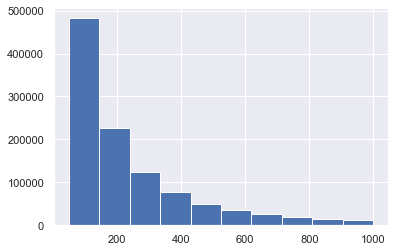

In [107]:
# The number of chars
df['review_body'].apply(len).hist()

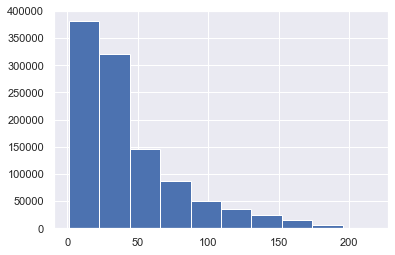

In [108]:
# The number of words
df['review_body'].apply(lambda x: len(x.split())).hist()

In [109]:
# Rating distribution (should be balanced)
df['star_rating'].value_counts().sort_index()

1    214164
2    210309
3    212546
4    215000
5    215000
Name: star_rating, dtype: int64

In [110]:
df['star_rating'].describe().apply(lambda x: '%.2f'%x)

count    1067019.00
mean           3.01
std            1.42
min            1.00
25%            2.00
50%            3.00
75%            4.00
max            5.00
Name: star_rating, dtype: object

In [111]:
# Category and rating distribution (should be balanced)
pd.crosstab(df['product_category'], df['star_rating'])

star_rating,1,2,3,4,5
product_category,,,,,
Apparel,5000,5000,5000,5000,5000
Automotive,5000,5000,5000,5000,5000
Baby,5000,5000,5000,5000,5000
Beauty,5000,5000,5000,5000,5000
Books,5000,5000,5000,5000,5000
Camera,5000,5000,5000,5000,5000
Digital_Ebook_Purchase,5000,5000,5000,5000,5000
Digital_Music_Purchase,5000,5000,5000,5000,5000
Digital_Software,5000,5000,5000,5000,5000


## Consolidate the data

In [116]:
def delete_files(csv_files):
    """Deletes the files."""
    for file in csv_files:
        try:
            if os.path.isfile(file):
                os.unlink(file)
        except Exception as e:
            print(e)

In [117]:
delete_files(csv_files)

In [121]:
df.to_csv(os.path.join(data_dir, 'amazon-reviews-balanced.csv'), header=True, index=False)

In [122]:
pd.read_csv(os.path.join(data_dir, 'amazon-reviews-balanced.csv')).head()

,product_category,review_body,star_rating
0,Digital_Software,I have been a loyal TurboTax customer since I ...,2
1,Digital_Software,I like the product BUT I don't like the fact t...,2
2,Digital_Software,This really wasn't what I needed. I'm use to u...,2
3,Digital_Software,Very disappointed this year. Have been using ...,2
4,Digital_Software,It just stopped working correctly. All produce...,2
